# Photon Time Propogation Grid Approach

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import PyPDF2

In [2]:
from MuDataFrame import *
import numpy as np
from scipy import stats

#loading the input data 
mdfo_calib = MuDataFrame("/Users/megan/Research/APDL/CrateAnalysis-master/data/Calibration/calibration_new_set_up.csv")

mdf_calib = mdfo_calib.events_df
#keeping 4by4 events meants events that passed through all 4 detector trays
mdfo_calib.keep4by4Events()
mdfo_calib.og_df = mdf_calib.copy()
mdfo_calib.show()

,Unnamed: 0,level_0,Unnamed: 0.1,index,event_num,event_time,deadtime,l1hit,l2hit,l3hit,...,z_angle,SmallCounter,speed,Run_Num,xx,yy,xx1,yy1,time_of_day,time
0,0,0,0,0,0,2021-05-03 12:40:15.812760,0,1.0,1.0,1.0,...,13.455446,NaN,0.342978,622,-5.445887,-22.562492,-6.807692,-22.684615,day,0
1,1,1,1,1,1,2021-05-03 12:40:16.502963,0,1.0,1.0,1.0,...,12.002813,NaN,0.703353,622,-11.762760,-21.506829,-11.538462,-21.784615,day,690203
2,2,2,2,2,2,2021-05-03 12:40:16.672924,0,1.0,1.0,1.0,...,14.672630,NaN,0.210716,622,35.347122,13.620282,36.676923,14.884615,day,860164
3,3,3,3,3,3,2021-05-03 12:40:16.892987,0,1.0,1.0,1.0,...,15.284964,NaN,0.259347,622,24.903617,25.826667,27.746154,29.153846,day,1080227
4,4,4,4,4,4,2021-05-03 12:40:17.563102,0,1.0,1.0,1.0,...,4.253100,NaN,11.038012,622,6.978340,14.482143,7.676923,15.230769,day,1750342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999992,2999992,2999992,2999992,99992,2999992,2021-05-20 13:18:29.305435,0,1.0,1.0,1.0,...,4.471381,NaN,2.208244,656,-24.827750,-14.125268,-25.330769,-14.146154,day,1077344492675
2999993,2999993,2999993,2999993,99993,2999993,2021-05-20 13:18:29.875548,0,1.0,1.0,1.0,...,15.702291,NaN,0.346495,656,13.468468,-38.856563,13.800000,-37.423077,day,1077345062788
2999994,2999994,2999994,2999994,99994,2999994,2021-05-20 13:18:30.125522,0,1.0,1.0,1.0,...,13.684312,NaN,0.276322,656,28.348837,-29.674472,28.130769,-29.230769,day,1077345312762
2999996,2999996,2999996,2999996,99996,2999996,2021-05-20 13:18:30.965416,0,1.0,1.0,1.0,...,6.035804,NaN,0.442759,656,12.892377,-12.244589,13.269231,-13.276923,day,1077346152656


### Getting Tray 1 and Tray 3 Channel Cuts

In [3]:
def getIntersections(t, curve1, curve2, doPlot=True):
    intersections = []
    xvals = []
    prev_dif = 0
    t0, prev_c1, prev_c2 = None, None, None
    for t1, c1, c2 in zip(t, curve1, curve2):
        new_dif = c2 - c1
        if np.abs(new_dif) < 1e-12:  # found an exact zero, this is very unprobable
            intersections.append((t1, c1))
        elif new_dif * prev_dif < 0:
            denom = prev_dif - new_dif
            xvals.append((-new_dif * t0 + prev_dif * t1) / denom)
            intersections.append(((-new_dif * t0 + prev_dif * t1) / denom,
                                  (c1 * prev_c2 - c2 * prev_c1) / denom))
        t0, prev_c1, prev_c2, prev_dif = t1, c1, c2, new_dif

    if doPlot:
        fig, ax = plt.subplots()
        ax.plot(t, curve1, 'b-')
        ax.plot(t, curve2, 'r-')
        ax.plot(*zip(*intersections), 'kx', ms=5)
        plt.show()
    
    diffs = np.diff(xvals)
    return xvals

#### Tray 1 Channel Cut Coordinates 

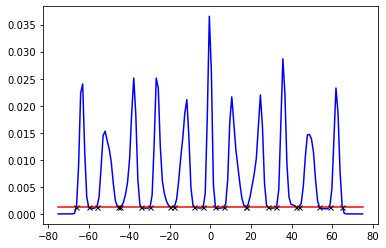

In [4]:
from scipy.stats import gaussian_kde
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data = mdfo_calib.get("diffL1")
bandwidth = 0.02
density1 = gaussian_kde(data, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density1(xs)
curve2 = len(curve1) * [0.00135]
vals = getIntersections(t, curve1, curve2)
L1cuts = np.reshape(vals,[11,2])

#### Tray 3 Channel Cut Coordinates

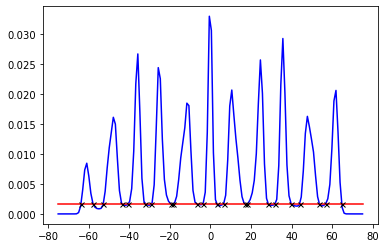

In [5]:
from scipy.stats import gaussian_kde
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
data = mdfo_calib.get("diffL3")
bandwidth = 0.025
density3 = gaussian_kde(data, bw_method=bandwidth)
xs = np.linspace(-75,75,150)
t = xs
curve1 = density3(xs)
curve2 = len(curve1) * [0.0017]
vals3 = getIntersections(t, curve1, curve2)
L3cuts = np.reshape(vals3,[11,2])

##### Isolating Channel 1 from Tray 1 to test

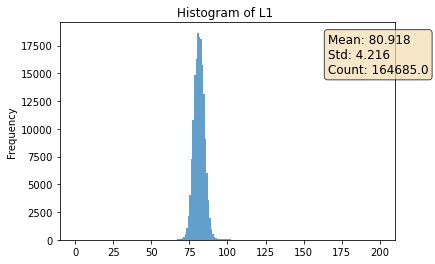

In [6]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("diffL1",L1cuts[0][1],"<=")
mdfo_calib.keepEvents("diffL1",L1cuts[0][0],">=")
mdfo_calib.getHistogram("L1", range=(0,200))
L1Ch1_df = mdfo_calib.events_df.L1.values

### Getting 11 square cuts on each channel bar of Tray 1 and Tray 3 Using TDC distribution

In [ ]:
"""
1. Create grid for L1/L3 with means and counts
-2. Save TDC dist for each channel in L1/L3
    2a. save figs individually and put into single pdf after for each layer
3. @shanto - Plot L1/L3 means with errors bars of std error


"""

In [26]:
#This function takes in layer cut coordinates that define discrete channels
#to create 11 equispaced steps to represent the cuts on orthogonal discrete channels. 
def getTDCCuts(data, layer, layercuts):
    L1_TDC_Cuts = []
    for i in layercuts:
        topDiff = "diffL" + str(layer)
        final = "L" + str(layer)
        data.reload()
        data.keep4by4Events()
        data.keepEvents(topDiff,i[1],"<=")
        data.keepEvents(topDiff,i[0],">=")
        TDCS = data.events_df.L1.values
    
        singleCh_Cuts = []
        upper = np.mean(TDCS) + np.std(TDCS) * 2.25 #try 2 std
        lower = np.mean(TDCS) - np.std(TDCS) * 2.25
        difference = upper - lower
        step_size = difference/11
        temp = np.arange(lower, upper, step_size)
        steps = np.append(temp, upper)
        for i in range(11):
            singleCh_Cuts.append((steps[i], steps[i+1]))
        L1_TDC_Cuts.append(singleCh_Cuts)
    return L1_TDC_Cuts

In [27]:
'''
Layer1cutsTDC holds the endpoints of 11 cuts made on the TDC dist that goes through each channel in Layer 1
For example:
    Layer1cutsTDC[0] holds 11 elements which represent the 11 orthogonal channels in Layer 1 Channel 1
    Layer1cutsTDC[0][0] holds a pair of TDC values that represent the endpoints for this TDC cut
'''
Layer1cutsTDC = getTDCCuts(mdfo_calib, 1, L1cuts)
Layer3cutsTDC = getTDCCuts(mdfo_calib, 3, L3cuts)

In [28]:
Layer3cutsTDC[0]

[(64.14661526179142, 70.1722600874685),
 (70.1722600874685, 76.19790491314558),
 (76.19790491314558, 82.22354973882265),
 (82.22354973882265, 88.24919456449973),
 (88.24919456449973, 94.27483939017681),
 (94.27483939017681, 100.30048421585388),
 (100.30048421585388, 106.32612904153096),
 (106.32612904153096, 112.35177386720804),
 (112.35177386720804, 118.37741869288512),
 (118.37741869288512, 124.40306351856219),
 (124.40306351856219, 130.4287083442393)]

In [29]:
print(Layer1cutsTDC[0][3])
print(np.mean(Layer1cutsTDC[0][3]))
#Layer1cutsTDC[0][0][0]

(76.60655646713613, 78.33109543112117)
77.46882594912864


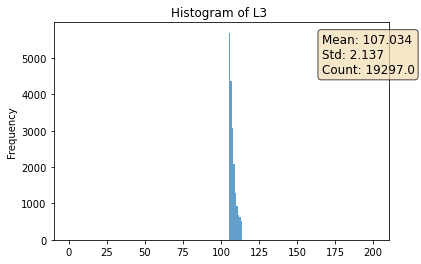

In [30]:
mdfo_calib.reload()
mdfo_calib.keep4by4Events()
mdfo_calib.keepEvents("diffL3",L3cuts[5][1],"<=")
mdfo_calib.keepEvents("diffL3",L3cuts[5][0],">=")
mdfo_calib.keepEvents("L3", Layer3cutsTDC[5][5][1], "<=")
mdfo_calib.keepEvents("L3", Layer3cutsTDC[5][5][0], ">=")

mdfo_calib.getHistogram("L3", range=(0,200))
# = mdfo_calib.events_df.L1.values

### Getting the Mean Value of each square cut and creating a 11x11 matrix of these values

In [91]:
#Gets the mean TDC value per square cut 
def getMeanPerCut(data, layer, chCuts, TDCcuts):
    Diff = "diffL" + str(layer)  
    final = "L" + str(layer)
    meansList = []
    stdList = []
    counts = []
    for i in range(11):
        for j in range(11):
            data.reload()
            data.keep4by4Events()
            data.keepEvents(Diff, chCuts[i][1],"<=")
            data.keepEvents(Diff,chCuts[i][0],">=")
            data.keepEvents(final, TDCcuts[i][j][1], "<=")
            data.keepEvents(final, TDCcuts[i][j][0], ">=")
            if (layer==1): vals = data.events_df.L1.values
            else: vals = data.events_df.L3.values
            singleMean = np.mean(vals)
            meansList.append(singleMean)
            singleStd = np.std(vals)
            stdList.append(singleStd)
            counts.append(len(vals))
    Organized = np.reshape(meansList,[11,11])
    Organized_std = np.reshape(stdList,[11,11])
    counts = np.reshape(counts,[11,11])

    return Organized, Organized_std, counts

In [32]:
mdfo_calib.reload()

In [33]:
L1_meanTDC, L1_stdTDC, L1_counts = getMeanPerCut(mdfo_calib, 1, L1cuts, Layer1cutsTDC)
L3_meanTDC, L3_stdTDC, L3_counts = getMeanPerCut(mdfo_calib, 3, L3cuts, Layer3cutsTDC)

In [88]:
"""#1"""
np.round(L1_meanTDC, 3), np.round(L1_counts, 3)

(array([[ 72.67 ,  74.   ,  75.64 ,  77.579,  79.533,  81.   ,  82.466,
          84.41 ,  86.   ,  87.354,  89.331],
        [ 76.687,  78.657,  81.262,  83.532,  85.504,  87.524,  89.491,
          91.447,  93.404,  95.383,  97.388],
        [ 80.324,  82.572,  85.197,  87.545,  90.062,  93.061,  95.501,
          97.812, 100.374, 102.664, 105.402],
        [ 84.553,  86.659,  89.21 ,  92.062,  94.512,  97.045,  99.91 ,
         102.799, 105.408, 107.707, 110.789],
        [ 86.582,  89.296,  92.159,  95.151,  98.062, 101.52 , 104.9  ,
         107.82 , 110.771, 113.767, 117.313],
        [ 92.298,  95.204,  98.182, 101.142, 104.065, 107.   , 109.938,
         112.813, 115.779, 118.73 , 121.792],
        [ 99.465, 102.327, 105.218, 108.152, 111.046, 113.962, 116.915,
         119.857, 122.405, 124.756, 127.84 ],
        [108.513, 111.443, 113.602, 116.038, 118.991, 121.529, 123.995,
         126.843, 129.415, 131.739, 134.782],
        [117.663, 120.405, 122.613, 125.156, 127.564, 13

In [89]:
np.round(L3_meanTDC, 3), np.round(L3_counts, 3)

(array([[ 67.905,  73.084,  78.358,  84.941,  91.095,  97.221, 103.173,
         109.   , 115.176, 121.417, 128.143],
        [ 70.408,  76.711,  83.821,  92.313, 101.203, 108.621, 116.343,
         126.1  , 135.125, 142.   , 151.5  ],
        [ 70.577,  78.066,  83.764,  90.991, 100.514, 108.927, 116.929,
         125.714, 135.125, 142.333, 153.25 ],
        [ 69.731,  77.593,  84.853,  91.617,  98.873, 107.845, 116.571,
         125.012, 133.516, 142.1  , 150.125],
        [ 68.783,  78.675,  85.79 ,  92.027,  99.606, 108.972, 116.89 ,
         124.579, 134.017, 142.019, 150.44 ],
        [ 70.   ,  79.029,  86.008,  93.29 ,  99.879, 107.034, 117.181,
         124.873, 132.362, 140.541, 149.619],
        [ 68.2  ,  78.333,  86.425,  93.934, 100.901, 108.755, 116.4  ,
         125.284, 133.572, 141.625, 150.469],
        [ 69.   ,  77.5  ,  87.25 ,  96.021, 102.701, 109.996, 117.469,
         125.02 , 133.548, 141.478, 151.164],
        [ 73.333,     nan,  86.2  ,  97.189, 105.761, 11

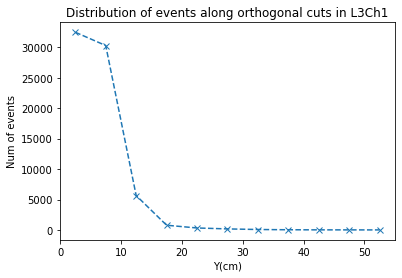

[32470 30288  5655   776   326   172    75    33    17    12     7]


In [113]:
"""#2"""
#[print(i) for i in L3_counts]
yrange = [5*j-2.5 for j in range(1,12)] 
ch = 0
plt.plot(yrange, L3_counts[ch], "--x")
plt.xlabel("Y(cm)")
plt.ylabel("Num of events")
plt.title("Distribution of events along orthogonal cuts in L3Ch{}".format(ch+1))
#plt.savefig("/Users/megan/Research/APDL/CrateAnalysis-master/data/PTP/L1Ch{}TDCdist".format(ch+1))
plt.show()
print(L3_counts[ch])

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 200)
yrange = [5*j-2.5 for j in range(1,12)]

for i in L1_counts: 
    plt.plot(yrange, L1_counts, '--x', linewidth = 1)
    plt.xlabel("Y(cm)")
    plt.ylabel("Number of Events")
    plt.yscale("log")
    plt.title("Distribution of events along orthogonal cuts in L1 All Channels")
#plt.savefig('L3 Event Counts.png')

In [ ]:
fig=plt.figure(figsize=(12,8), dpi= 200)
yrange = [5*j-2.5 for j in range(1,12)]

for i in L3_counts: 
    plt.plot(yrange, L3_counts, '--x', linewidth = 1)
    plt.xlabel("Y(cm)")
    plt.ylabel("Number of Events")
    plt.yscale("log")
    plt.title("Distribution of events along orthogonal cuts in L3 All Channels")
#plt.savefig('L3 Event Counts.png')

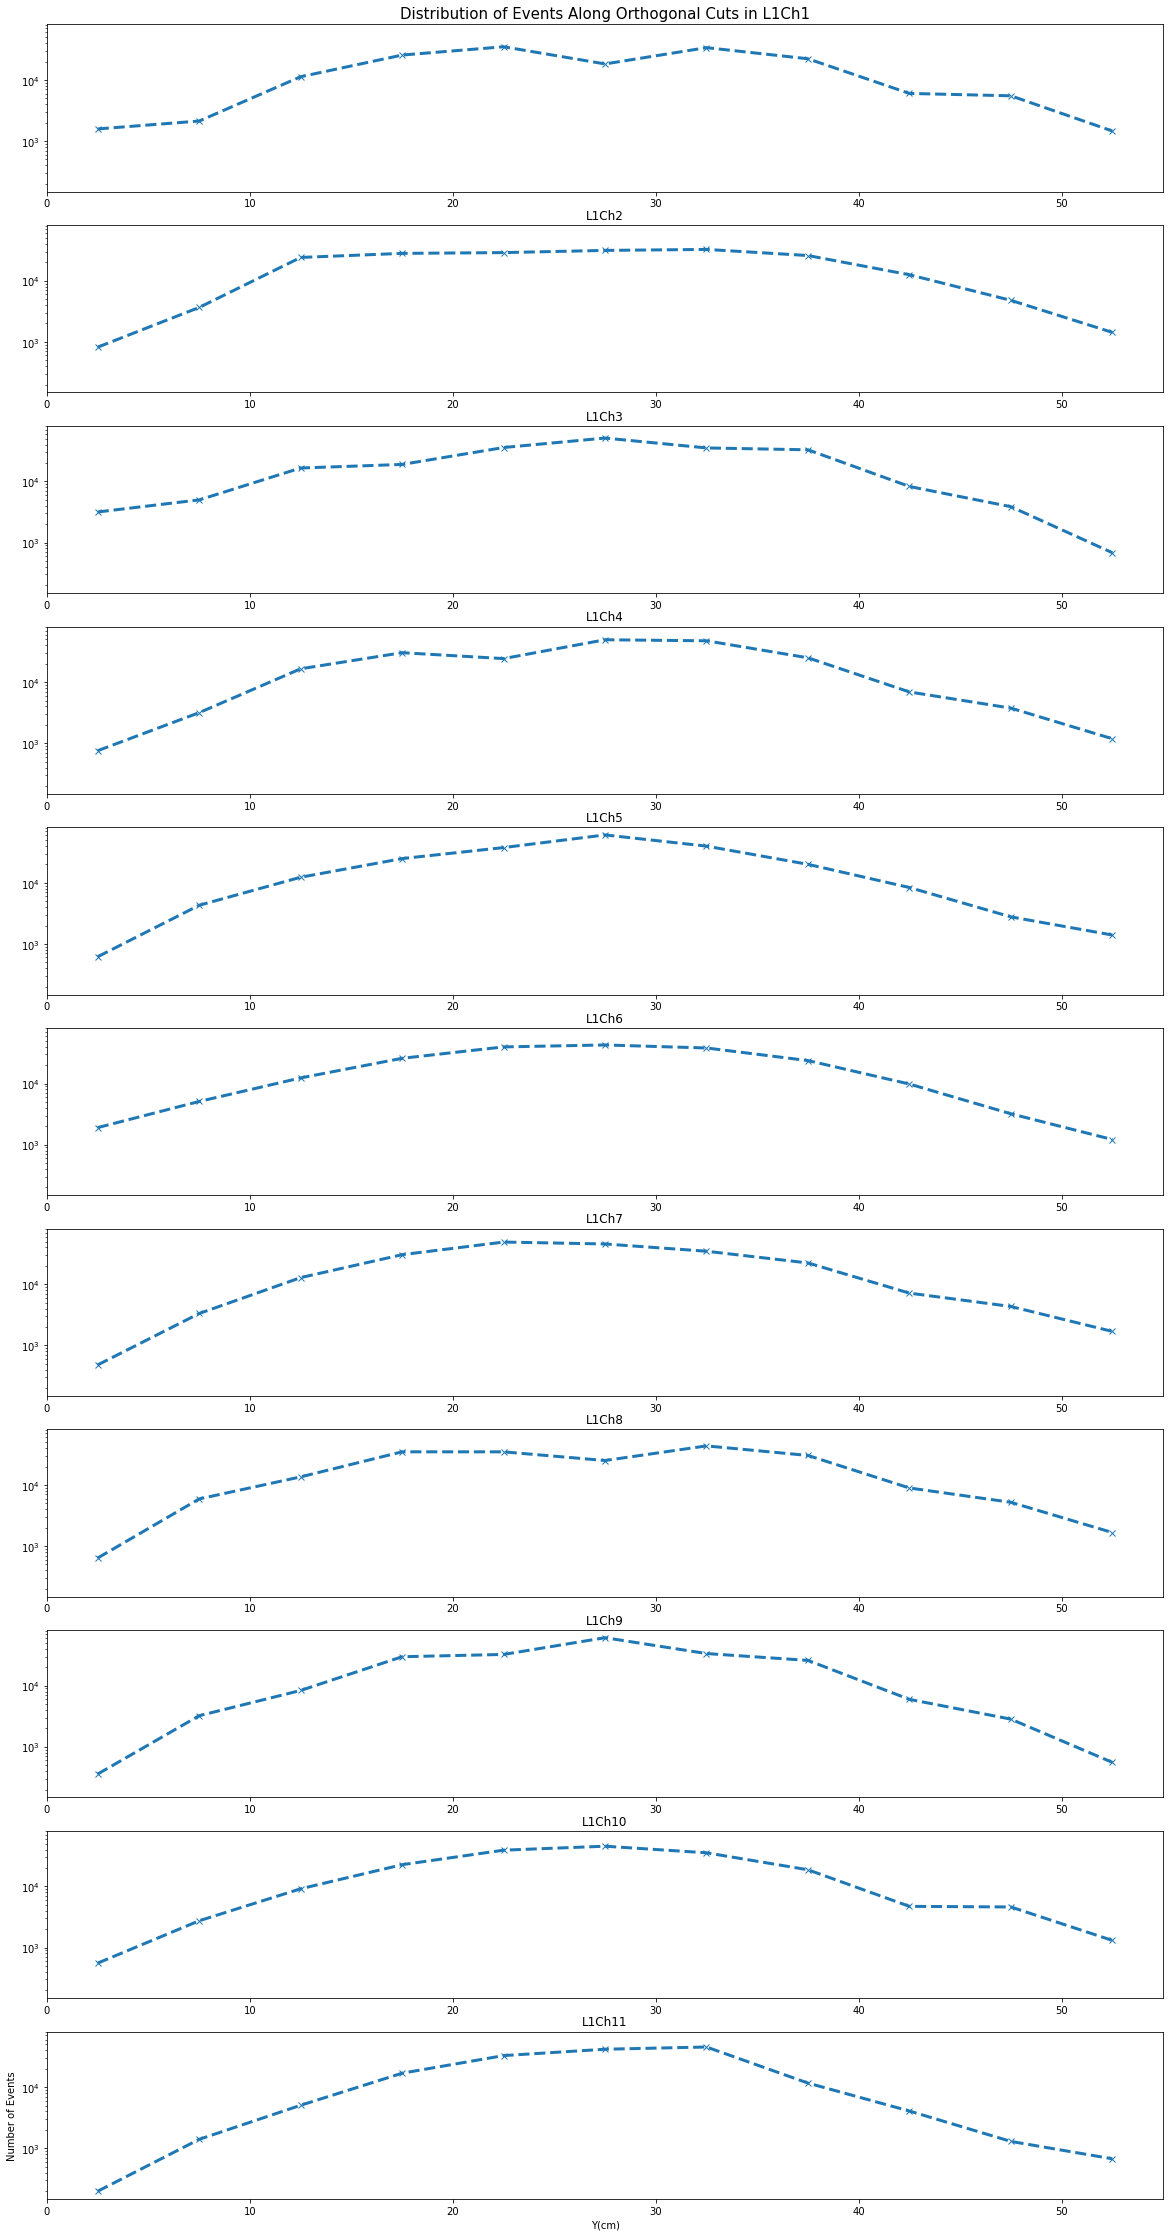

In [298]:
fig, axs = plt.subplots(11, sharey=True)
fig.set_figheight(40)
fig.set_figwidth(20)
plt.xlabel("Y(cm)")
plt.ylabel("Number of Events")
axs[0].set_title('Distribution of Events Along Orthogonal Cuts in L1Ch1', fontsize=15)
plt.yscale("log")
axs[1].set_title('L1Ch2')
plt.yscale("log")
axs[2].set_title('L1Ch3')
plt.yscale("log")
axs[3].set_title('L1Ch4')
plt.yscale("log")
axs[4].set_title('L1Ch5')
plt.yscale("log")
axs[5].set_title('L1Ch6')
plt.yscale("log")
axs[6].set_title('L1Ch7')
plt.yscale("log")
axs[7].set_title('L1Ch8')
plt.yscale("log")
axs[8].set_title('L1Ch9')
plt.yscale("log")
axs[9].set_title('L1Ch10')
plt.yscale("log")
axs[10].set_title('L1Ch11')
plt.yscale("log")
axs[0].plot(yrange, L1_counts[0], '--x', linewidth = 3)
axs[1].plot(yrange, L1_counts[1], '--x', linewidth = 3)
axs[2].plot(yrange, L1_counts[2], '--x', linewidth = 3)
axs[3].plot(yrange, L1_counts[3], '--x', linewidth = 3)
axs[4].plot(yrange, L1_counts[4], '--x', linewidth = 3)
axs[5].plot(yrange, L1_counts[5], '--x', linewidth = 3)
axs[6].plot(yrange, L1_counts[6], '--x', linewidth = 3)
axs[7].plot(yrange, L1_counts[7], '--x', linewidth = 3)
axs[8].plot(yrange, L1_counts[8], '--x', linewidth = 3)
axs[9].plot(yrange, L1_counts[9], '--x', linewidth = 3)
axs[10].plot(yrange, L1_counts[10], '--x', linewidth = 3)

plt.savefig('/Users/megan/Research/APDL/CrateAnalysis-master/data/PTP/L1 Event Counts.pdf')

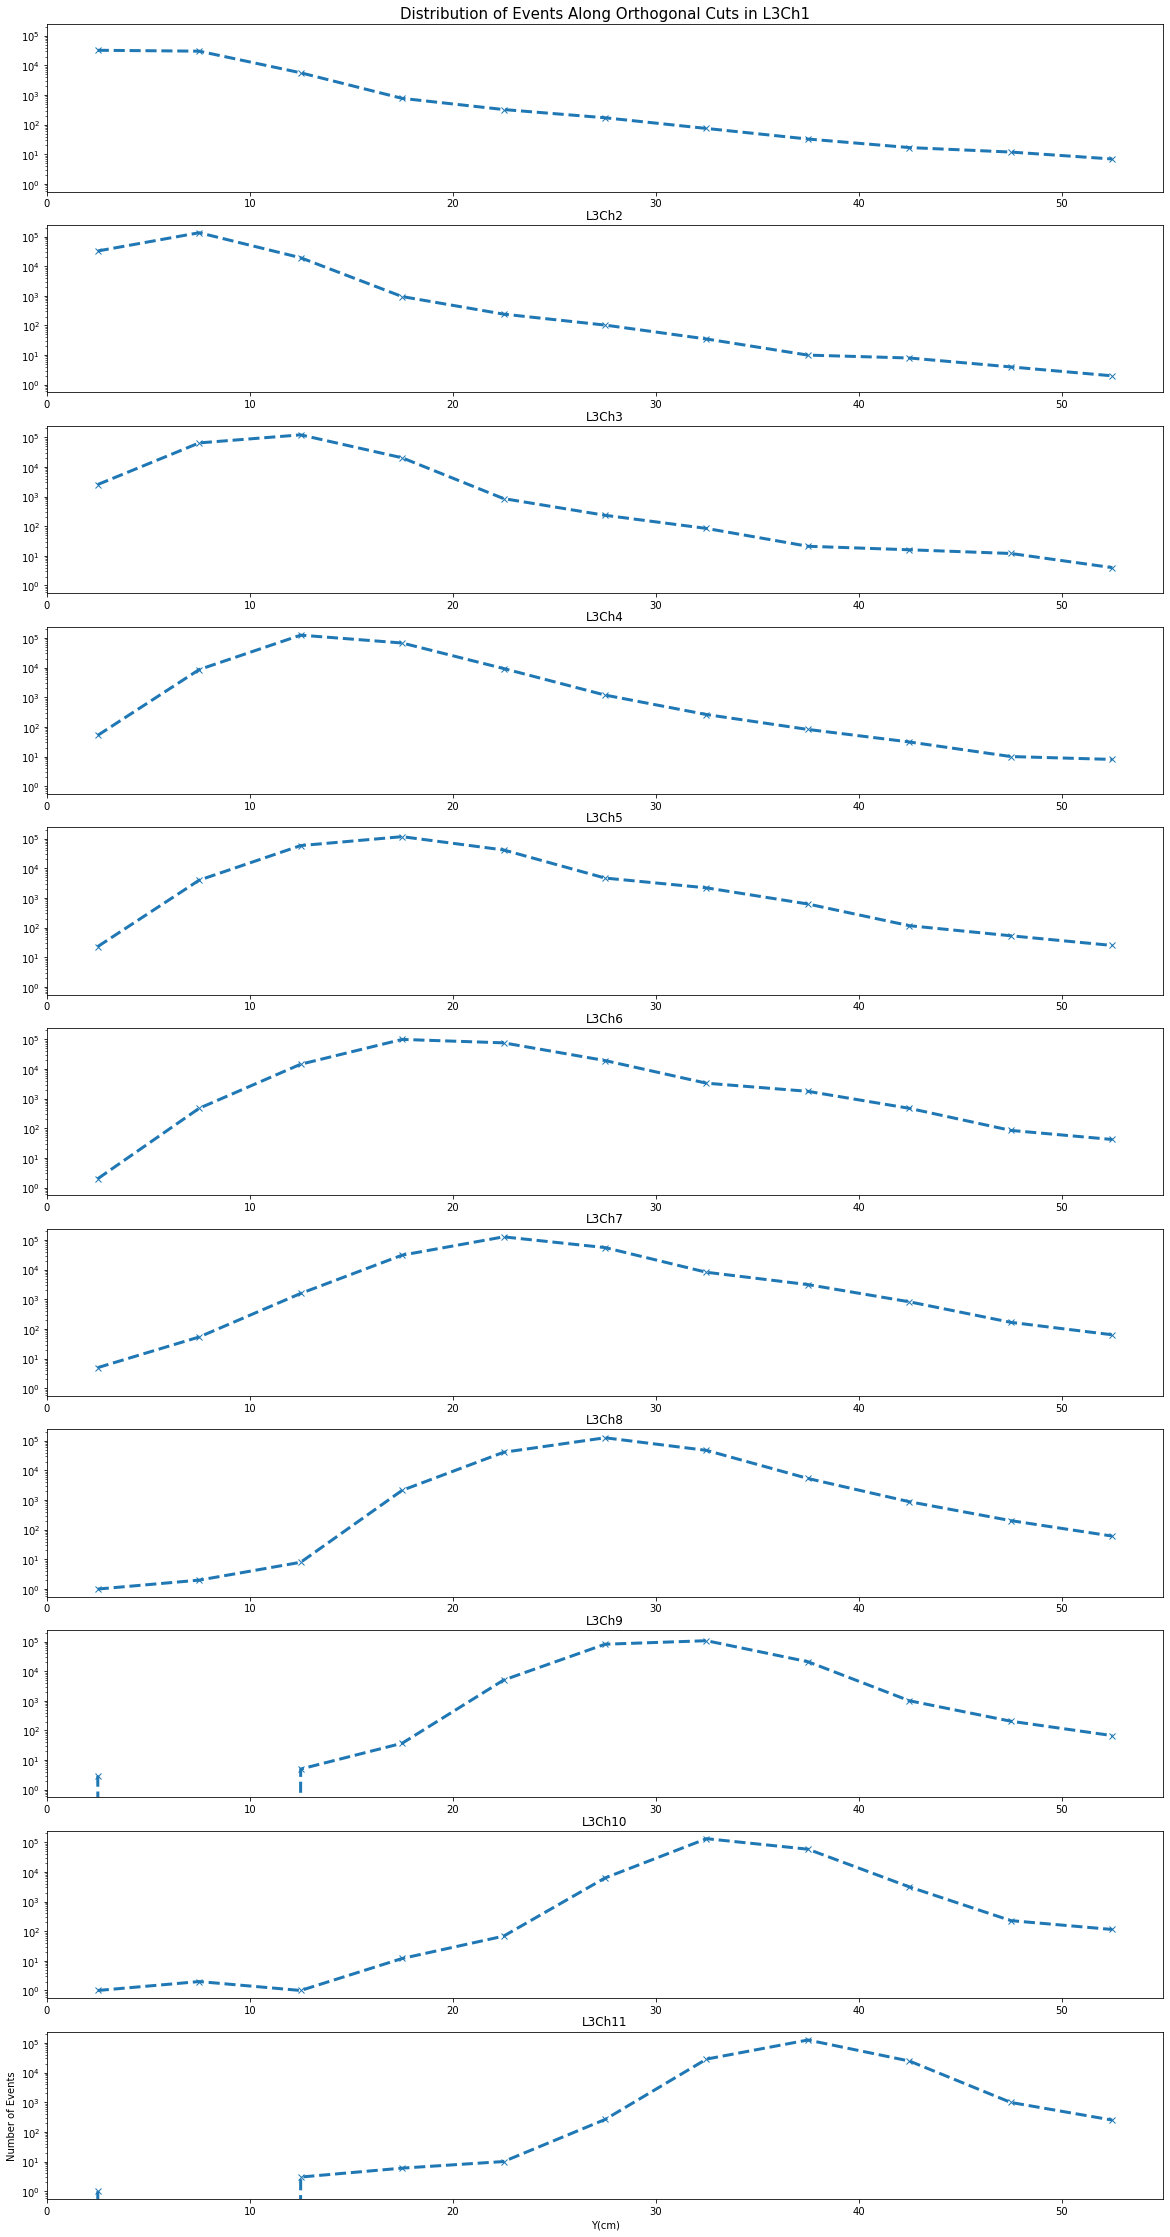

In [299]:
fig, axs = plt.subplots(11, sharey= True)
fig.set_figheight(40)
fig.set_figwidth(20)
plt.xlabel("Y(cm)")
plt.ylabel("Number of Events")
axs[0].set_title('Distribution of Events Along Orthogonal Cuts in L3Ch1', fontsize=15)
plt.yscale("log")
axs[1].set_title('L3Ch2')
plt.yscale("log")
axs[2].set_title('L3Ch3')
plt.yscale("log")
axs[3].set_title('L3Ch4')
plt.yscale("log")
axs[4].set_title('L3Ch5')
plt.yscale("log")
axs[5].set_title('L3Ch6')
plt.yscale("log")
axs[6].set_title('L3Ch7')
plt.yscale("log")
axs[7].set_title('L3Ch8')
plt.yscale("log")
axs[8].set_title('L3Ch9')
plt.yscale("log")
axs[9].set_title('L3Ch10')
plt.yscale("log")
axs[10].set_title('L3Ch11')
plt.yscale("log")
axs[0].plot(yrange, L3_counts[0], '--x', linewidth = 3)
axs[1].plot(yrange, L3_counts[1], '--x', linewidth = 3)
axs[2].plot(yrange, L3_counts[2], '--x', linewidth = 3)
axs[3].plot(yrange, L3_counts[3], '--x', linewidth = 3)
axs[4].plot(yrange, L3_counts[4], '--x', linewidth = 3)
axs[5].plot(yrange, L3_counts[5], '--x', linewidth = 3)
axs[6].plot(yrange, L3_counts[6], '--x', linewidth = 3)
axs[7].plot(yrange, L3_counts[7], '--x', linewidth = 3)
axs[8].plot(yrange, L3_counts[8], '--x', linewidth = 3)
axs[9].plot(yrange, L3_counts[9], '--x', linewidth = 3)
axs[10].plot(yrange, L3_counts[10], '--x', linewidth = 3)

plt.savefig('/Users/megan/Research/APDL/CrateAnalysis-master/data/PTP/L3 Event Counts.pdf')

In [109]:
L1diff_Y1_Y11 = []
L3diff_Y1_Y11 = []
for i in range(11):
    L1diff_Y1_Y11.append(L1_meanTDC[i][10]- L1_meanTDC[i][0])
    L3diff_Y1_Y11.append(L3_meanTDC[i][10]- L3_meanTDC[i][0])

L1diff_Y1_Y11

[16.66099784565779,
 20.701457733945546,
 25.077871307681804,
 26.236119482954933,
 30.73127394414955,
 29.49484025312816,
 28.375251182033097,
 26.268341636836965,
 24.734529368148927,
 18.35091743119267,
 22.16575591985429]

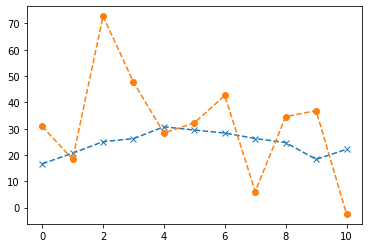

In [17]:
plt.plot(L1diff_Y1_Y11, '--x')
plt.plot(L3diff_Y1_Y11, '--o')
plt.show()

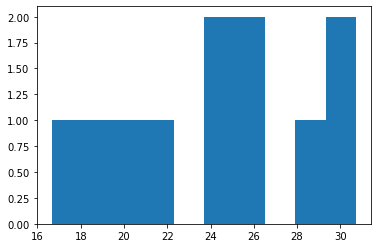

In [18]:
plt.hist(L1diff_Y1_Y11)
plt.show()

In [95]:
L3diff_Y1_Y11

[60.238299089269205,
 81.09188889573197,
 82.67266824085006,
 80.39423076923077,
 81.65739130434783,
 79.61904761904762,
 82.26875,
 82.1639344262295,
 78.35323383084578,
 81.23684210526315,
 78.78399999999999]